In [56]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [57]:
import jax
import numpy as np
import matplotlib.pyplot as plt 
import galsim as _galsim


In [58]:
jax.__version__, _galsim.__version__


('0.4.16', '2.5.0')

In [59]:
jax.devices()


[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [60]:
jax.config.update("jax_default_device", jax.devices()[0])


In [61]:
import jax
import jax.numpy as jnp
import jax_galsim as galsim
from jax import random

from jax import device_get, device_put


In [62]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random


In [63]:
from tqdm import tqdm


In [64]:
import bpd
from bpd.chains import run_chains
from bpd.draw import add_noise


In [65]:
from numpyro.diagnostics import summary, gelman_rubin, effective_sample_size, print_summary


## Forward model

In [81]:
PSF_HLR = 0.7
PIXEL_SCALE = 0.2
SLEN = 51
BACKGROUND = 100

N_GAL = 2

# galaxy
TRUE_HLR = 0.9
LOG_TRUE_FLUX = 4.5
TRUE_FLUX = 10**LOG_TRUE_FLUX

# positions 
POS = jnp.array([[-5.0,0.0],
                 [7.5,0.0]]
               )
 
#shear (per bin)
G = jnp.array([[0.02, 0], 
               [-0.02, 0]]
             )

# which tomographic bin
N_TOMO = 2
TOMO_BINS = jnp.array([0, 1])

LF = jnp.array([LOG_TRUE_FLUX, LOG_TRUE_FLUX]) 
HLR = jnp.array([TRUE_HLR, TRUE_HLR])


assert len(TOMO_BINS) == POS.shape[0] == len(HLR) == len(LF) == N_GAL
assert len(jnp.unique(TOMO_BINS)) == G.shape[0] == N_TOMO



#params
TRUE_PARAMS = {'lfs': LF, 'hlrs': HLR, 'gs': G, 'poss': POS, 'tomo_bins':TOMO_BINS}
TRUE_PARAMS = {k:v[None] for k,v in TRUE_PARAMS.items()}
# TRUE_PARAMS_ARR = {k:jnp.array([v]) for k,v in TRUE_PARAMS.items()}


In [85]:
# get true image (no noise)
def _draw_gals():
    fim = np.zeros((SLEN,SLEN))
    for ii in range(N_GAL):
        gal = _galsim.Gaussian(flux=TRUE_FLUX, half_light_radius=TRUE_HLR)
        t = TOMO_BINS[ii]
        gal = gal.shear(g1=G[t, 0], g2=G[t, 1])
        dx, dy = POS[ii]
        pos = _galsim.PositionD(x=dx, y=dy)
        psf = _galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
        gal_conv = _galsim.Convolve([gal, psf])
        im = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE, 
                                  offset=pos)
        fim += im.array
        
    return fim


In [86]:
GSPARAMS = galsim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.vmap
@jax.jit
def draw_gals(lfs, hlrs,  gs, poss, tomo_bins):
    fim = jnp.zeros((SLEN, SLEN))
    for ii in range(N_GAL):
        lf = lfs[ii] 
        hlr = hlrs[ii]
        x, y = poss[ii]
        t = tomo_bins[ii]
        g1, g2 = gs[t]
        
        gal = galsim.Gaussian(flux=10**lf, half_light_radius=hlr)
        gal = gal.shear(g1=g1, g2=g2)
        
        pos = galsim.PositionD(x=x, y=y)
        psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
        gal_conv = galsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
        image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                               offset=pos, 
                               )
        fim += image.array
    return fim



In [75]:
data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=10)
data.shape

(10, 51, 51)

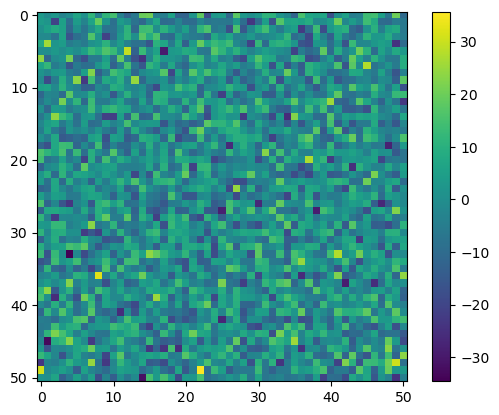

In [88]:
# check error is very small on true thingies
TRUE_IMAGE = _draw_gals()
image, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
arr = image[0] - draw_gals(**TRUE_PARAMS)[0]
plt.imshow(arr)
plt.colorbar()


In [96]:
jnp.repeat(TOMO_BINS[None], 4, axis=0)

Array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int32)

In [164]:
import math
def prob_model(data):
    batch_dim, _, _ = data.shape

    with numpyro.plate('b', batch_dim, dim=-2):
    
        # global shears, one per tomo bin.
        g11 = numpyro.sample('g11', dist.Uniform(-0.1, 0.1))
        g12 = numpyro.sample('g12', dist.Uniform(-0.1, 0.1))
        g21 = numpyro.sample('g21', dist.Uniform(-0.1, 0.1))
        g22 = numpyro.sample('g22', dist.Uniform(-0.1, 0.1))
        g = [ [[a[0], b[0]],[c[0],d[0]]] for (a,b,c,d) in zip(g11,g12,g21,g22)]
        g = jnp.array(g)
        # g = jnp.array([[g11, g12],[g21,g22]]).reshape(batch_dim, 2, 2)
        # print(g.shape)
        # print(g)
        with numpyro.plate('n', N_GAL, dim=-1):
            lf = numpyro.sample('lf', dist.Uniform(3,6))
            hlr = numpyro.sample('hlr', dist.Uniform(0.5, 1.5))
        # assert False
        # print(lf.shape)
    # repeat for vectorization
    _pos = jnp.repeat(POS[None], batch_dim, axis=0)
    _tomo_bins = jnp.repeat(TOMO_BINS[None], batch_dim, axis=0)
    
    im = draw_gals(lf, hlr, g, _pos, _tomo_bins)
    numpyro.sample('obs', dist.Normal(im, math.sqrt(BACKGROUND)), obs=data)


In [165]:
a = jnp.array([1,1])
b = jnp.array([2, 2])
c = jnp.array([3,3])
d = jnp.array([4,4]) 
abcd = [ [[ai.item(),bi.item()],[ci.item(),di.item()]] for ai,bi,ci,di in zip(a,b,c,d)]
print(abcd[0])

[[1, 2], [3, 4]]


In [181]:
from numpyro.infer.initialization import init_to_median

data, _ = add_noise(TRUE_IMAGE, BACKGROUND, n=1)
nuts_kernel = NUTS(prob_model, max_tree_depth=10, 
            # init_strategy=init_to_median,  find_heuristic_step_size=True
                  )
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=4000, 
            num_chains=1, chain_method="sequential")
rng_key = random.PRNGKey(11)
mcmc.run(rng_key, data=data)


sample: 100%|██████████| 5000/5000 [16:20<00:00,  5.10it/s, 31 steps of size 9.48e-02. acc. prob=0.91]   


In [190]:
# snapshot
samples = mcmc.get_samples(group_by_chain=False)
samples['g11'][:, 3, 0].mean(), samples['g21'][:, 3, 0].mean(), samples['g11'][:, 3, 0].std(), samples['g21'][:, 3, 0].std()

(Array(0.03900391, dtype=float32),
 Array(-0.02547435, dtype=float32),
 Array(0.00944851, dtype=float32),
 Array(0.00960506, dtype=float32))

In [186]:
 samples['g21'].shape

(4000, 4, 1)

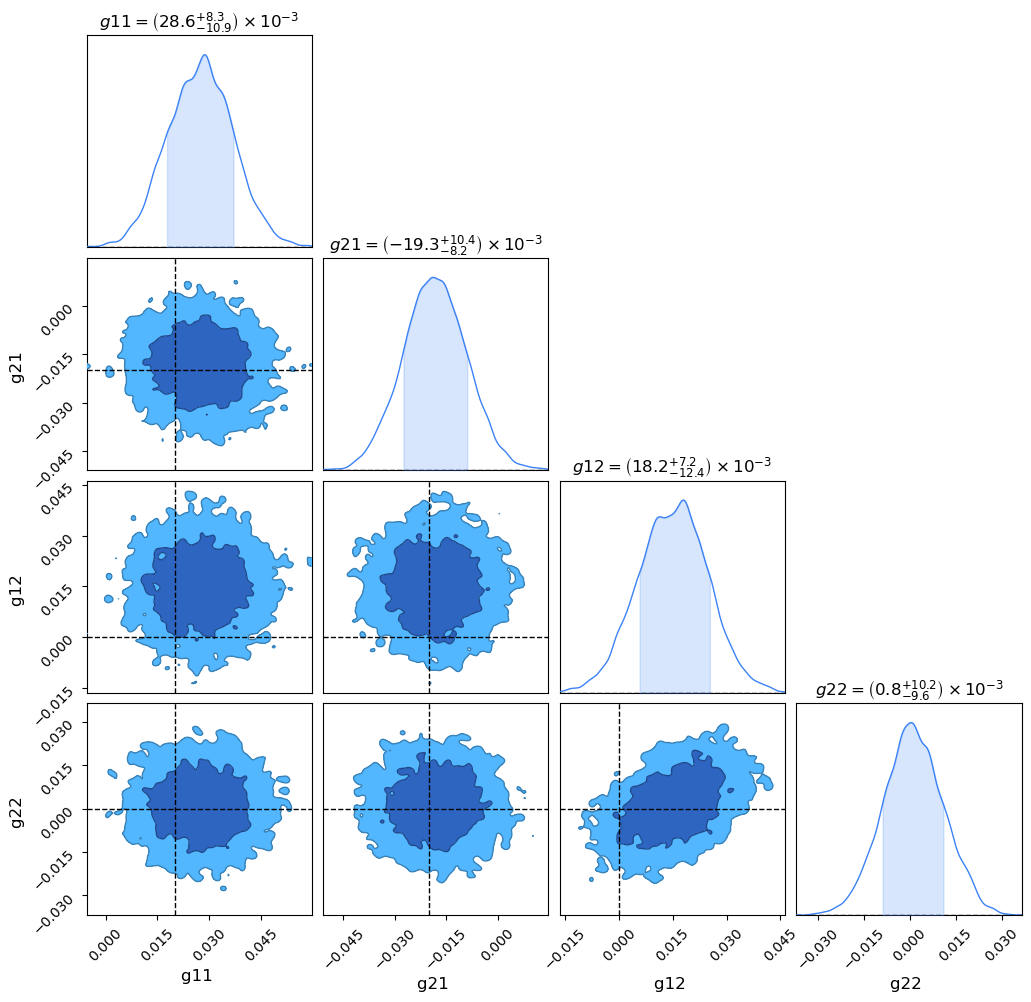

In [43]:
# example of corner plots for 1 chain
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
_samples = {k:samples0[k] for k in ['g11', 'g21', 'g12', 'g22']}
df =pd.DataFrame.from_dict(_samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location={'g11':0.02, 'g21':-0.02, 'g12': 0.00, 'g22':0.00}))
fig = c.plotter.plot()

In [27]:
# samples = {k:v.reshape(4, 4000, -1) for k,v in mcmc.get_samples(group_by_chain=True).items()}
# samples0 = {k:v.reshape(4, 4000, -1)[0].squeeze() for k,v in mcmc.get_samples(group_by_chain=True).items()}
# samples['g11'].shape, samples['lf'].shape

In [53]:
# diagnostics for multiple chains ( >= 4) 
from numpyro.diagnostics import split_gelman_rubin, gelman_rubin

print('gelman-rubin')
for k in ['g11', 'g21', 'g12', 'g22']:
    print(k, gelman_rubin(samples[k]), _gelman_rubin(samples[k][:,:]))
print()



gelman-rubin
g11 1.0002452 1.0004903
g21 1.0000515 1.0001031
g12 1.0002521 1.0005044
g22 1.0001453 1.0002908



In [55]:
jax.local_device_count()

4